In [21]:
import warnings
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import sys
import optuna


warnings.filterwarnings('ignore')

In [22]:
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

In [23]:
import config

In [6]:
test = pd.read_csv(config.TEST_FILE)
train = pd.read_csv(config.TRAINING_FILE)
contact = pd.read_csv(config.CONTACT_FILE)

In [7]:
train.head()

,cellid,phase,order_within_phase,order
0,SCG0088_CTATGAGGTACCGGAT-1,G1,0,0
1,SCG0088_GCTAAGCGTATTGGTG-1,G1,0,0
2,SCG0089_TCCATTGTCTGTAAGC-1,G1,0,0
3,SCG0092_GTTTATCTCATGCTAA-1,G1,0,0
4,SCG0092_AACCGCTCAGCTCATA-1,G1,0,0


In [8]:
train["order"].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43])

In [9]:
train["order_within_phase"].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [10]:
test.head()

,cellid,phase,order_within_phase,order
0,SCG0089_CTTATGTTCCCGCCTA-1,NaN,NaN,NaN
1,SCG0093_AGAACCGCACAGCCAT-1,NaN,NaN,NaN
2,SCG0090_CCAGGATGTGCTCACC-1,NaN,NaN,NaN
3,SCG0089_TACCTTTAGCACTTGG-1,NaN,NaN,NaN
4,SCG0092_TGATCAGGTTTGAGGC-1,NaN,NaN,NaN


In [11]:
contact.head()

,chr1,start1,end1,chr2,start2,end2,cellid
0,chr13-M,74316813,74316959,chr13-M,72727004,72727154,SCG0088_TTTAACCTCAGCCAAT-1
1,chr1-M,79322530,79322563,chr12-M,4538118,4538268,SCG0088_TATAGGTGTCCCGGAA-1
2,chr2-M,75633331,75633491,chr8-P,125695812,125695962,SCG0088_CGTTAACAGTACCGCA-1
3,chr7-P,136324163,136324313,chr7-P,136352442,136352592,SCG0088_TTTAACCTCAGCCAAT-1
4,chr6-M,49253365,49253515,chr6-M,49323546,49323680,SCG0088_CGTTAACAGTACCGCA-1


In [12]:
print(contact.shape)
total_contacts = contact.shape[0]

(5679074, 7)


## Feature Engineering

In [13]:
contact.head()

,chr1,start1,end1,chr2,start2,end2,cellid
0,chr13-M,74316813,74316959,chr13-M,72727004,72727154,SCG0088_TTTAACCTCAGCCAAT-1
1,chr1-M,79322530,79322563,chr12-M,4538118,4538268,SCG0088_TATAGGTGTCCCGGAA-1
2,chr2-M,75633331,75633491,chr8-P,125695812,125695962,SCG0088_CGTTAACAGTACCGCA-1
3,chr7-P,136324163,136324313,chr7-P,136352442,136352592,SCG0088_TTTAACCTCAGCCAAT-1
4,chr6-M,49253365,49253515,chr6-M,49323546,49323680,SCG0088_CGTTAACAGTACCGCA-1


In [14]:
from scipy.stats import skew, kurtosis

# 1. Flags for chromosome origins: maternal (M) and paternal (P)
contact["is_m_chr1"] = contact["chr1"].str.endswith("M").astype(int)
contact["is_m_chr2"] = contact["chr2"].str.endswith("M").astype(int)
contact["is_p_chr1"] = contact["chr1"].str.endswith("P").astype(int)
contact["is_p_chr2"] = contact["chr2"].str.endswith("P").astype(int)

# 2. Calculate contact lengths
contact["length1"] = contact["end1"] - contact["start1"]
contact["length2"] = contact["end2"] - contact["start2"]

# 3. Interaction frequencies between chromosomes
chr1_chr2_contacts = contact.groupby(
    "chr1")["chr2"].size().rename("chr1_chr2_count")
chr2_chr1_contacts = contact.groupby(
    "chr2")["chr1"].size().rename("chr2_chr1_count")
contact = contact.merge(chr1_chr2_contacts, on="chr1", how="left")
contact = contact.merge(chr2_chr1_contacts, on="chr2", how="left")

# 4. Calculate distances between contacts (as differences and absolute values)
contact["start_distance"] = contact["start1"] - contact["start2"]
contact["end_distance"] = contact["end1"] - contact["end2"]
contact["abs_start_distance"] = contact["start_distance"].abs()
contact["abs_end_distance"] = contact["end_distance"].abs()

# 5. Length ratio of contacts (asymmetry)
contact["length_ratio"] = contact["length1"] / (contact["length2"] + 1e-5)

# 6. Categorize contacts: intra (within the same chromosome) and inter (between chromosomes)
contact["intra_contact"] = (contact["chr1"] == contact["chr2"]).astype(int)
contact["inter_contact"] = (contact["chr1"] != contact["chr2"]).astype(int)

# 7. Categorize distances: create categories for abs_start_distance and abs_end_distance
threshold_short = 200e3  # 200 thousand nucleotides
threshold_mid = 2e6      # 2 million nucleotides

contact["bin_start"] = np.where(contact["abs_start_distance"] < threshold_short, "short",
                                np.where(contact["abs_start_distance"] <= threshold_mid, "mid", "long"))
contact["bin_end"] = np.where(contact["abs_end_distance"] < threshold_short, "short",
                              np.where(contact["abs_end_distance"] <= threshold_mid, "mid", "long"))

# 8. Define inter-origin contacts: maternal-maternal, paternal-paternal, and mixed
contact["mm_contact"] = ((contact["is_m_chr1"] == 1) &
                         (contact["is_m_chr2"] == 1)).astype(int)
contact["pp_contact"] = ((contact["is_p_chr1"] == 1) &
                         (contact["is_p_chr2"] == 1)).astype(int)
contact["mp_contact"] = (((contact["is_m_chr1"] == 1) & (contact["is_p_chr2"] == 1)) |
                         ((contact["is_p_chr1"] == 1) & (contact["is_m_chr2"] == 1))).astype(int)

# 9. Count unique chromosome pairs for each cell (sorted alphabetically)


def unique_chr_pairs(df):
    pairs = df.apply(lambda row: tuple(
        sorted([row["chr1"], row["chr2"]])), axis=1)
    return pairs.nunique()


unique_pairs = contact.groupby("cellid").apply(
    unique_chr_pairs).rename("unique_chr_pairs")

# 10. Additional distance distribution characteristics: skewness and kurtosis


def compute_skew(series):
    return skew(series) if len(series) > 1 else 0


def compute_kurtosis(series):
    return kurtosis(series) if len(series) > 1 else 0


skew_start = contact.groupby("cellid")["abs_start_distance"].apply(
    compute_skew).rename("skew_abs_start")
kurtosis_start = contact.groupby("cellid")["abs_start_distance"].apply(
    compute_kurtosis).rename("kurtosis_abs_start")
skew_end = contact.groupby("cellid")["abs_end_distance"].apply(
    compute_skew).rename("skew_abs_end")
kurtosis_end = contact.groupby("cellid")["abs_end_distance"].apply(
    compute_kurtosis).rename("kurtosis_abs_end")

# 11. Aggregate features at the cell level (including new biologically relevant features)
agg_features = contact.groupby("cellid").agg(
    # General contact characteristics
    total_contacts=("chr1", "count"),

    # Distances between contacts
    median_start_distance=("start_distance", "median"),
    median_end_distance=("end_distance", "median"),
    min_start_distance=("start_distance", "min"),
    min_end_distance=("end_distance", "min"),
    max_start_distance=("start_distance", "max"),
    max_end_distance=("end_distance", "max"),
    std_start_distance=("start_distance", "std"),
    std_end_distance=("end_distance", "std"),
    median_abs_start_distance=("abs_start_distance", "median"),
    median_abs_end_distance=("abs_end_distance", "median"),

    # Contact lengths and their ratios
    median_length1=("length1", "median"),
    median_length2=("length2", "median"),
    mean_length1=("length1", "mean"),
    mean_length2=("length2", "mean"),
    median_length_ratio=("length_ratio", "median"),
    mean_length_ratio=("length_ratio", "mean"),

    # Chromosome origin flags
    sum_is_m_chr1=("is_m_chr1", "sum"),
    sum_is_m_chr2=("is_m_chr2", "sum"),
    sum_is_p_chr1=("is_p_chr1", "sum"),
    sum_is_p_chr2=("is_p_chr2", "sum"),

    # Interaction frequencies between chromosomes
    mean_chr1_chr2_count=("chr1_chr2_count", "mean"),
    std_chr1_chr2_count=("chr1_chr2_count", "std"),
    mean_chr2_chr1_count=("chr2_chr1_count", "mean"),
    std_chr2_chr1_count=("chr2_chr1_count", "std"),

    # Intra and inter contacts
    intra_contacts=("intra_contact", "sum"),
    inter_contacts=("inter_contact", "sum"),

    # Categorization by distance (start)
    long_contacts_start=("bin_start", lambda x: (x == "long").sum()),
    mid_contacts_start=("bin_start", lambda x: (x == "mid").sum()),
    short_contacts_start=("bin_start", lambda x: (x == "short").sum()),
    # Categorization by distance (end)
    long_contacts_end=("bin_end", lambda x: (x == "long").sum()),
    mid_contacts_end=("bin_end", lambda x: (x == "mid").sum()),
    short_contacts_end=("bin_end", lambda x: (x == "short").sum()),

    # Inter-origin contacts
    mm_contacts=("mm_contact", "sum"),
    pp_contacts=("pp_contact", "sum"),
    mp_contacts=("mp_contact", "sum")
).fillna(0)

# 12. Add additional features: unique chromosome pairs and distance distribution characteristics
agg_features = (agg_features
                .merge(unique_pairs, left_index=True, right_index=True)
                .merge(skew_start, left_index=True, right_index=True)
                .merge(kurtosis_start, left_index=True, right_index=True)
                .merge(skew_end, left_index=True, right_index=True)
                .merge(kurtosis_end, left_index=True, right_index=True))

# 13. Additional ratios
agg_features["ratio_intra"] = agg_features["intra_contacts"] / \
    (agg_features["total_contacts"] + 1e-5)
agg_features["ratio_inter"] = agg_features["inter_contacts"] / \
    (agg_features["total_contacts"] + 1e-5)
agg_features["ratio_mm"] = agg_features["mm_contacts"] / \
    (agg_features["total_contacts"] + 1e-5)
agg_features["ratio_pp"] = agg_features["pp_contacts"] / \
    (agg_features["total_contacts"] + 1e-5)
agg_features["ratio_mp"] = agg_features["mp_contacts"] / \
    (agg_features["total_contacts"] + 1e-5)

# Ratios for distance categories (start)
agg_features["ratio_short_start"] = agg_features["short_contacts_start"] / \
    (agg_features["total_contacts"] + 1e-5)
agg_features["ratio_mid_start"] = agg_features["mid_contacts_start"] / \
    (agg_features["total_contacts"] + 1e-5)
agg_features["ratio_long_start"] = agg_features["long_contacts_start"] / \
    (agg_features["total_contacts"] + 1e-5)
# Similarly for end
agg_features["ratio_short_end"] = agg_features["short_contacts_end"] / \
    (agg_features["total_contacts"] + 1e-5)
agg_features["ratio_mid_end"] = agg_features["mid_contacts_end"] / \
    (agg_features["total_contacts"] + 1e-5)
agg_features["ratio_long_end"] = agg_features["long_contacts_end"] / \
    (agg_features["total_contacts"] + 1e-5)
# 15. Ratio of very short contacts (<50 kb)
very_short_threshold = 50e3
contact["is_very_short"] = (
    contact["abs_start_distance"] < very_short_threshold).astype(int)
very_short_agg = contact.groupby("cellid").agg(
    very_short_contacts=("is_very_short", "sum")
)
# Use the total number of contacts from the previous aggregation (agg_features)
very_short_agg["ratio_very_short"] = very_short_agg["very_short_contacts"] / \
    (agg_features["total_contacts"] + 1e-5)

# 16. Median lengths for intra and inter contacts
intra_contacts = contact[contact["intra_contact"] == 1]
inter_contacts = contact[contact["intra_contact"] == 0]

intra_medians = intra_contacts.groupby("cellid").agg(
    median_length1_intra=("length1", "median"),
    median_length2_intra=("length2", "median")
)
inter_medians = inter_contacts.groupby("cellid").agg(
    median_length1_inter=("length1", "median"),
    median_length2_inter=("length2", "median")
)

# Merge with main aggregates
agg_features = agg_features.merge(
    intra_medians, left_index=True, right_index=True, how="left")
agg_features = agg_features.merge(
    inter_medians, left_index=True, right_index=True, how="left")
agg_features["ratio_median_length1_intra_inter"] = agg_features["median_length1_intra"] / \
    (agg_features["median_length1_inter"] + 1e-5)
agg_features["ratio_median_length2_intra_inter"] = agg_features["median_length2_intra"] / \
    (agg_features["median_length2_inter"] + 1e-5)

# 17. Contact decay exponent


def compute_decay_slope(distances):
    if len(distances) < 10:
        return np.nan
    try:
        # Define 7 bins on a logarithmic scale from 1e2 to the maximum distance
        bin_edges = np.logspace(2, np.log10(distances.max()+1), num=7)
    except Exception:
        bin_edges = np.linspace(0, distances.max()+1, 7)
    counts, edges = np.histogram(distances, bins=bin_edges)
    mid_points = (edges[:-1] + edges[1:]) / 2
    valid = counts > 0
    if valid.sum() < 2:
        return np.nan
    log_mid = np.log10(mid_points[valid])
    log_counts = np.log10(counts[valid])
    slope, _ = np.polyfit(log_mid, log_counts, 1)
    return slope


decay_slope = contact.groupby("cellid")["abs_start_distance"].apply(
    compute_decay_slope).rename("decay_slope")

# 18. Difference between maternal and paternal contacts (chr1 and chr2 separately)
agg_features["diff_m_p_chr1"] = agg_features["sum_is_m_chr1"] - \
    agg_features["sum_is_p_chr1"]
agg_features["diff_m_p_chr2"] = agg_features["sum_is_m_chr2"] - \
    agg_features["sum_is_p_chr2"]

# 19. Entropy of distribution by distance categories (using bin_start)


def bin_entropy(series):
    probs = series.value_counts(normalize=True)
    return -np.sum(probs * np.log(probs + 1e-5))


entropy_bin_start = contact.groupby("cellid")["bin_start"].apply(
    bin_entropy).rename("entropy_bin_start")
entropy_bin_end = contact.groupby("cellid")["bin_end"].apply(
    bin_entropy).rename("entropy_bin_end")

# 20. Merge additional features into the main agg_features table
agg_features = agg_features.merge(
    very_short_agg[["ratio_very_short"]], left_index=True, right_index=True, how="left")
agg_features = agg_features.merge(
    decay_slope, left_index=True, right_index=True, how="left")
agg_features = agg_features.merge(
    entropy_bin_start, left_index=True, right_index=True, how="left")
agg_features = agg_features.merge(
    entropy_bin_end, left_index=True, right_index=True, how="left")

# Fill missing values for new features
agg_features.fillna(0, inplace=True)

# Merge final features with training and test sets
train = train.merge(agg_features, on="cellid", how="left")
test = test.merge(agg_features, on="cellid", how="left")

In [27]:
train.to_csv("../input/processed_train.csv", index=False)
test.to_csv("../input/processed_test.csv", index=False)

In [156]:
train.head()

,cellid,phase,order_within_phase,order,total_contacts,median_start_distance,median_end_distance,min_start_distance,min_end_distance,max_start_distance,...,median_length1_inter,median_length2_inter,ratio_median_length1_intra_inter,ratio_median_length2_intra_inter,diff_m_p_chr1,diff_m_p_chr2,ratio_very_short,decay_slope,entropy_bin_start,entropy_bin_end
0,SCG0088_CTATGAGGTACCGGAT-1,G1,0,0,2544,-3083.5,-3136.0,-157735287,-157735390,138895729,...,141.0,140.0,0.535461,1.071428,-360,-404,0.528302,-0.027953,0.905115,0.905115
1,SCG0088_GCTAAGCGTATTGGTG-1,G1,0,0,2245,-828.0,-896.0,-145560608,-145560516,162532950,...,109.0,138.0,0.477064,1.086956,-213,-251,0.566592,-0.045906,0.862500,0.862500
2,SCG0089_TCCATTGTCTGTAAGC-1,G1,0,0,2038,-1204.0,-1251.0,-148714493,-148714367,162097207,...,111.5,127.0,0.493273,1.173228,-62,-74,0.570658,-0.062338,0.865186,0.865186
3,SCG0092_GTTTATCTCATGCTAA-1,G1,0,0,4164,-2022.0,-2056.0,-162678755,-162678683,183634905,...,141.0,135.0,0.411347,1.111111,130,134,0.541066,-0.028831,0.882389,0.882389
4,SCG0092_AACCGCTCAGCTCATA-1,G1,0,0,2451,-980.0,-1006.0,-155115912,-155115912,165218506,...,137.0,99.0,0.386861,1.494949,-199,-217,0.585883,-0.063766,0.827496,0.827496


## Model

In [157]:
y = train["phase"]
X = train.drop(["cellid", "phase",
               "order", "order_within_phase"], axis=1)

In [158]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [159]:
print("Encoded y:", y_encoded[:5])
print("X features:", X.columns.tolist())

Encoded y: [0 0 0 0 0]
X features: ['total_contacts', 'median_start_distance', 'median_end_distance', 'min_start_distance', 'min_end_distance', 'max_start_distance', 'max_end_distance', 'std_start_distance', 'std_end_distance', 'median_abs_start_distance', 'median_abs_end_distance', 'median_length1', 'median_length2', 'mean_length1', 'mean_length2', 'median_length_ratio', 'mean_length_ratio', 'sum_is_m_chr1', 'sum_is_m_chr2', 'sum_is_p_chr1', 'sum_is_p_chr2', 'mean_chr1_chr2_count', 'std_chr1_chr2_count', 'mean_chr2_chr1_count', 'std_chr2_chr1_count', 'intra_contacts', 'inter_contacts', 'long_contacts_start', 'mid_contacts_start', 'short_contacts_start', 'long_contacts_end', 'mid_contacts_end', 'short_contacts_end', 'mm_contacts', 'pp_contacts', 'mp_contacts', 'unique_chr_pairs', 'skew_abs_start', 'kurtosis_abs_start', 'skew_abs_end', 'kurtosis_abs_end', 'ratio_intra', 'ratio_inter', 'ratio_mm', 'ratio_pp', 'ratio_mp', 'ratio_short_start', 'ratio_mid_start', 'ratio_long_start', 'ratio_

## Model evaluation with KFold

In [116]:
train.shape

(1501, 33)

In [117]:
def objective(trial):
    params = {
        'objective': 'multi:softmax',
        'num_class': 3,
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'random_state': 42,
        'n_jobs': -1
    }

    scores = []
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, val_idx in cv.split(X, y_encoded):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]

        model = XGBClassifier(**params, early_stopping_rounds=50)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )

        y_pred = model.predict(X_val)
        scores.append(accuracy_score(y_val, y_pred))

    return np.mean(scores)

In [ ]:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=10, timeout=3600)

[I 2025-02-27 14:26:54,269] A new study created in memory with name: no-name-2557b9f3-2c9c-4c14-9527-2e9dfa49c24a
[I 2025-02-27 14:27:42,595] Trial 0 finished with value: 0.6302458471760797 and parameters: {'booster': 'dart', 'learning_rate': 0.04329683968158647, 'max_depth': 6, 'n_estimators': 719, 'subsample': 0.8306272348137163, 'colsample_bytree': 0.8104909671700431, 'gamma': 0.30436881860270604, 'reg_alpha': 0.6485664350474025, 'reg_lambda': 0.44450814609077693}. Best is trial 0 with value: 0.6302458471760797.
[I 2025-02-27 14:27:58,115] Trial 1 finished with value: 0.6222547065337763 and parameters: {'booster': 'dart', 'learning_rate': 0.25572205050392205, 'max_depth': 5, 'n_estimators': 202, 'subsample': 0.9738350871135497, 'colsample_bytree': 0.8951808483279196, 'gamma': 0.11649774923309153, 'reg_alpha': 0.20941521572473354, 'reg_lambda': 0.15739561327168528}. Best is trial 0 with value: 0.6302458471760797.
[I 2025-02-27 14:28:15,019] Trial 2 finished with value: 0.619581395348

In [160]:
best_params = {'booster': 'dart',
               'learning_rate': 0.06003045121841921,
               'max_depth': 4,
               'n_estimators': 620,
               'subsample': 0.8808977267646029,
               'colsample_bytree': 0.6994151120782637,
               'gamma': 0.29938976579104853,
               'reg_alpha': 0.28087865686560587,
               'reg_lambda': 0.8010940381702771,
               "n-jobs": -1,
               "random_state": 42,
               "objective": "multi:softmax",
               "num_class": 3
               }

In [161]:
print("Best parameters:", best_params)

Best parameters: {'booster': 'dart', 'learning_rate': 0.06003045121841921, 'max_depth': 4, 'n_estimators': 620, 'subsample': 0.8808977267646029, 'colsample_bytree': 0.6994151120782637, 'gamma': 0.29938976579104853, 'reg_alpha': 0.28087865686560587, 'reg_lambda': 0.8010940381702771, 'n-jobs': -1, 'random_state': 42, 'objective': 'multi:softmax', 'num_class': 3}


In [171]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [172]:
accuracy_scores = []

In [168]:
xgb_clf = XGBClassifier(**best_params)
lgb_params = {
    'learning_rate': 0.05,
    'n_estimators': 600,
    'max_depth': 4,
    'random_state': 42
}
lgb_clf = lgb.LGBMClassifier(**lgb_params)
cat_params = {
    'iterations': 600,
    'depth': 4,
    'learning_rate': 0.05,
    'loss_function': 'MultiClass',
    'random_seed': 42
}
cat_clf = CatBoostClassifier(**cat_params, verbose=0)

In [169]:
ensemble = VotingClassifier(estimators=[
    ('xgb', xgb_clf),
    ('lgb', lgb_clf),
    ('cat', cat_clf)
], voting='soft')

In [ ]:
# for train_idx, val_idx in folds.split(X, y_encoded):
#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]

#     ensemble.fit(X_train, y_train)
#     y_pred = ensemble.predict(X_val)
#     accuracy = accuracy_score(y_val, y_pred)
#     accuracy_scores.append(accuracy)
#     print(f"Fold accuracy: {accuracy:.4f}")

# mean_accuracy = np.mean(accuracy_scores)
# print(f"\nMean cross-validated accuracy: {mean_accuracy:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14999
[LightGBM] [Info] Number of data points in the train set: 1200, number of used features: 64
[LightGBM] [Info] Start training from score -1.337504
[LightGBM] [Info] Start training from score -0.616186
[LightGBM] [Info] Start training from score -1.622017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

In [177]:
import pickle

with open('../models/ensemble_0682.pkl', 'wb') as f:
    pickle.dump(ensemble, f)

In [170]:
# for train_idx, val_idx in folds.split(X, y_encoded):
#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]

#     model = XGBClassifier(**best_params, early_stopping_rounds=50)
#     model.fit(
#         X_train, y_train,
#         eval_set=[(X_val, y_val)],
#         verbose=False
#     )

#     y_pred = model.predict(X_val)
#     accuracy = accuracy_score(y_val, y_pred)
#     accuracy_scores.append(accuracy)
#     print(f"Fold accuracy: {accuracy:.4f}")

# mean_accuracy = np.mean(accuracy_scores)
# print(f"\nMean cross-validated accuracy: {mean_accuracy:.4f}")

In [165]:
def plot_feature_importances(model):
    n_features = X.shape[1]
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)

    plt.figure(figsize=(8, 6))
    plt.barh(range(n_features),
             feature_importances[sorted_idx], align="center")
    plt.yticks(np.arange(n_features), X.columns[sorted_idx])
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.title("Feature Importances")
    plt.show()

    # Print feature names and their importance
    for idx in sorted_idx:
        print(f"{X.columns[idx]}: {feature_importances[idx]}")

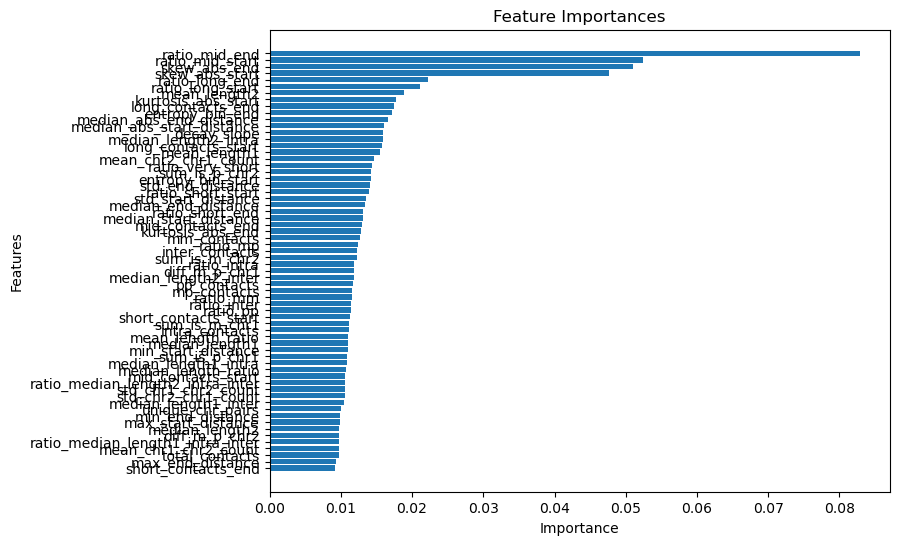

short_contacts_end: 0.009214257821440697
max_end_distance: 0.009286437183618546
total_contacts: 0.009683837182819843
mean_chr1_chr2_count: 0.009690890088677406
ratio_median_length1_intra_inter: 0.00972842052578926
diff_m_p_chr2: 0.00977861788123846
median_length2: 0.009794450365006924
max_start_distance: 0.009866365231573582
min_end_distance: 0.009916631504893303
unique_chr_pairs: 0.010040635243058205
median_length1_inter: 0.01047460176050663
std_chr2_chr1_count: 0.010511958971619606
std_chr1_chr2_count: 0.010554373264312744
ratio_median_length2_intra_inter: 0.010614592581987381
mid_contacts_start: 0.01062114629894495
median_length_ratio: 0.010653703473508358
median_length1_intra: 0.010799077339470387
sum_is_p_chr1: 0.010903794318437576
min_start_distance: 0.010951383039355278
median_length1: 0.010963182896375656
mean_length_ratio: 0.010983958840370178
intra_contacts: 0.011114235036075115
sum_is_m_chr1: 0.011205869726836681
short_contacts_start: 0.011346741579473019
ratio_pp: 0.0113609

In [166]:
plot_feature_importances(model)